In [2]:
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib.pyplot import figure
from scipy.stats import mannwhitneyu
import numpy as np

In [13]:
all_types=pd.read_pickle("../01_preparation/clear-fusion/clear-fusion_tama_augustus.pkl")

### Input

In [3]:
gene_template={'alternative_3end5end':0,
        'at_least_one_novel_splicesite':0,
        'alternative_3end':0,
        'intron_retention':0,
        'mono-exon':0,
        '3prime_fragment':0,
        'multi-exon':0,
        '5prime_fragment':0,
        'combination_of_known_splicesites':0,
        'reference_match':0,
        'alternative_5end':0,
        'internal_fragment':0,
        'mono-exon_by_intron_retention':0,
        'combination_of_known_junctions':0,
        'fusion':0}

In [4]:
weights={'reference_match':0.05,
         'alternative_3end':0.1,
         'alternative_5end':0.1,
         'alternative_3end5end':0.1,
         'combination_of_known_splicesites':0.2,
         'combination_of_known_junctions':0.2,
         '3prime_fragment':0.3,
         '5prime_fragment':0.3,
         'internal_fragment':0.3,
         'mono-exon':0.15,
         'multi-exon':0.15,
         'mono-exon_by_intron_retention':0.2,
         'fusion':0.5,
         'at_least_one_novel_splicesite':0.5,
         'intron_retention':0.5}

1) The ORF is calculated with the Shannon Entropy, explaining the total information content of the gene. The relation of different alternative splicing events (AS-events) to the resulting open reading frames (ORFs) is the key part of gene vaiability based on isoforms. One advantage of this method is the resulting value of 0 if only one open reading frame is found. This means zero variability in the gene, even though a variety of different alternative splicing (AS) events are found:

    Let $o_i$ be the number of occurences of ORF $i$ in a gene with $n$ different reported ORFs and $m$ total isoforms (log2 for bit representation! Scale by maximum possible entropy (relative entropy) Distinguish between 0 caused by 1 read or by true invariability).

$$ORFscore = -\sum_{i = 1}^{n} {o_i \over m} * {\log {o_i \over m}}$$

2) In a wider extend, gene variability not only includes the number of isoforms and ORFs, but also AS events leading to the ORFs and the impact of an AS event on protein structure after translation. The variability of the first two events is covered by the $ORFscore$, while the latter ones are adressed differently:
    The first task is to identify gene loci with specific AS events happening more frequently than in others. Assigning simple score based on the number of event-categories do fit here. For every AS event $i$ in a gene, compute the relative frequency within the gene with respect to the total amount of isoforms $m$: 
$$freq_i ={n_i  \over m}$$ 

3) To account for the impact on protein structure, a general score to summarize the category variability is introduced. Each of the AS events an have a differing effect on translation and thus, the means are weighted. The logic of these (so far arbitrary chosen) weights is as follows:\
    Low (0-0.1): We used AUGUSTUS annotations lacking UTRs, so we expect these categories enriched in our analysis (Data show this!), weights are low. Same for reference matches since they add even less variability.\
    Low (0.15): From Luisa: Mono and multi exons within the gene, but with non-matching splice junctions are likely some randomness and not too meaningful.\
    Medium (0.2): Combination of known splice sites and junctions do add variability, but are just combining prior knowledge and are less likely (?) to mess with total protein structure. Mono-exons by intron retention form a different case compared to the mono/multi-exons as desctibe before. Here, two or more exons are fused, but have known and valid 5'/3' splice junctions.\
    Medium (0.3-0.4): This section describes the ISM section of SQANTI, in which complete parts of a gene are missing. From fragments at the 3' and/or 5' ends up to only a mono exon or multiple ones, whole domains could be missing in the later protein (RPP7 with FPA)\
    High (0.5+): Intron retention can add a several things to a gene, including stop codons, frameshifts etc. This also is true for fusion genes, basically being an intergenic retention. Since AUGUSTUS predicts genes based on patterns in sequence, novel splicing sites are quite interesting, since non-canonical splice sites exist and they add quite a bit of "unusual" variability.
    
    Let $freq_i$ be the relative frequency of a specific AS event $i$ out of $n$ AS event-categories (see gene template) and $w_i$ the assigned weight, calculate the weighted mean as follows:
$$EVENTscore = {\sum_{i = 1}^{n} freq_i * w_i \over \sum_{i = 1}^{n} w_i}$$

4) VARscore: Last, take the product of the $ORFscore$ and the $EVENTscore$ to "normalize" the weighted mean with the general information content. This results in a score, combining all variability metrics described in 2:

$$VARscore = ORFscore * EVENTscore$$

5) Comment: One issue I could see here is that the weighted mean turns to 1 if only one AS is present. On the other hand, this gives a reason to "normalize" by the Shanon Entropy again, as a ration of 1 AS event to 1 ORF would turn to 0 again. If more ORFs are present, the variability score of the ORFs is multiplied by 1, giving high variability most likely. 


6) Shannon entropy is between 0 and 1. calculate the likelihood of a different ORF, if you have 3 or more transcripts (Bayes).
If 0 is reported AND an ORF is supported by 3 (or any n) or less transcipts/reads, 

In [5]:
#v3 (weigthed mean)
import math
from scipy.stats import entropy
import numpy as np

def iso_var(df):
    df=df.copy()
    # get n isoforms per gene
    isoforms=len(df["isoform"].tolist())
    # get n orfs per gene
    orfs=len(set(df["Sqanti_ORF_seq"].tolist()))

    ###--------------------------------------###
    ### get n isoforms per ORF (-->ORF score)###
    # include NA, since they are noncoding
    df["isoforms_per_orf"]=df.groupby(by=["Sqanti_ORF_seq"], dropna=False)["isoform"].transform(lambda x: len(x.tolist()))
    iso_per_orf=[]
    for orf in df.groupby("Sqanti_ORF_seq", dropna=False):
        iso_per_orf.append(orf[1]["isoforms_per_orf"].unique().item())
    # get chance of finding an ORF
    ratio=iso_per_orf/np.sum(iso_per_orf)
    # absolute values of the log: take log, since we will never get above 1. 
    # And if you have 1, there is no variability since all Isoforms encode the same ORF.
    # This could be an issue if you want to look at 3'5' differences...

    ## Test1
    #log = np.log(ratio) #google shannon entropy in python    
    # variability score of orf distribution:
    #orf_val = -(np.sum(log))

    ## Shannon entropy
    orf_val = entropy(ratio)


    ###--------------------------------------###
    ### get Category Score
    # split clear cases and fusion genes:
    c=df[~(df["structural_category"]=="fusion")]
    f=df[df["structural_category"]=="fusion"]
    #create out_df
    out_df=pd.DataFrame([gene_template])
    
    ## handle clear cases:
    occ=dict(c["subcategory"].value_counts())
    # weighted mean metrics
    num = 0
    den = 0
    
    for cat in occ.keys():
        # get frequency
        cat_val=occ[cat]/isoforms
        # fill df
        out_df[cat] = [cat_val]
        # and save the frequency*weight + weight for weighted mean calculation
        num += occ[cat]*weights[cat]/isoforms
        den += weights[cat]

    # add fusion isoforms (relative frequency)
    if len(f) > 0:
        out_df["fusion"]=[len(f)/isoforms]
        num += (len(f)*weights["fusion"])/isoforms
        den += weights["fusion"]
        
    # CAT score (weighted mean):
    out_df["cat_score"] = [num/den]
    
    # add ORF score
    out_df["orf_score"] = orf_val
    
    #fill na
    out_df.fillna(0,inplace=True)
    
    # multiply the category variability score with the variability score of the ORFs
    out_df["var_score"]= out_df["cat_score"]*orf_val

    return out_df

In [6]:
var_scores_all=pd.DataFrame()
for acc in tqdm(all_types["accession"].unique().tolist()):
    
    nlr_acc=all_types.loc[(all_types["accession"]==f"{acc}")].copy()
    acc_var=pd.DataFrame()
    
    #nlr_acc=all_types.loc[(all_types["accession"]==f"{acc}")&(all_types["type"]=="nlr")].copy()
    for i in nlr_acc.groupby(by="gene", as_index=False):
        gene_var=iso_var(i[1])
        gene_var["gene"]=i[0]
        if "nlr" in i[1]["type"].tolist():
            gene_var["type"]="nlr"
        else:
            gene_var["type"]="other"
        acc_var=pd.concat([acc_var, gene_var])
    #acc_df=pd.DataFrame({"value":acc_var, "gene":acc_gene, "type":acc_type})
    acc_var["accession"]=acc
    var_scores_all=pd.concat([var_scores_all, acc_var]).fillna(0)
    #print(nlr_acc.groupby(by="gene", as_index=False))
var_scores_all.to_pickle("var_scores_nlr-other.pkl")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [25:48<00:00, 86.02s/it]


## Evaluation
### Example gene

In [3]:
var_scores_all=pd.read_pickle("var_scores_nlr-other.pkl")

In [4]:
var_scores_all

,alternative_3end5end,at_least_one_novel_splicesite,alternative_3end,intron_retention,mono-exon,3prime_fragment,multi-exon,5prime_fragment,combination_of_known_splicesites,reference_match,...,internal_fragment,mono-exon_by_intron_retention,combination_of_known_junctions,fusion,cat_score,orf_score,var_score,gene,type,accession
0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000,0.0,0.000000,...,0.0,0.0,0.0,0.0,1.000000,0.000000,0.000000,G1,other,at6923
0,0.500000,0.045455,0.227273,0.045455,0.090909,0.090909,0.00,0.000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.096419,1.031820,0.099487,G10,other,at6923
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00,0.000,0.0,0.000000,...,0.0,0.0,0.0,0.0,1.000000,0.000000,0.000000,G100,other,at6923
0,0.333333,0.083333,0.416667,0.166667,0.000000,0.000000,0.00,0.000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.166667,1.118743,0.186457,G1000,other,at6923
0,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.75,0.000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.500000,0.661563,0.330782,G10000,other,at6923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.025000,0.125000,0.025000,0.000000,0.025000,0.350000,0.00,0.025,0.0,0.150000,...,0.0,0.0,0.0,0.0,0.136719,1.651755,0.225826,G9995,other,col0
0,0.088235,0.088235,0.352941,0.000000,0.000000,0.000000,0.00,0.000,0.0,0.264706,...,0.0,0.0,0.0,0.0,0.143599,0.395372,0.056775,G9996,other,col0
0,0.000000,0.000000,0.166667,0.166667,0.000000,0.000000,0.00,0.000,0.0,0.500000,...,0.0,0.0,0.0,0.0,0.188889,0.867563,0.163873,G9997,other,col0
0,0.000000,0.000000,0.166667,0.166667,0.000000,0.000000,0.00,0.000,0.0,0.500000,...,0.0,0.0,0.0,0.0,0.188889,0.450561,0.085106,G9998,other,col0


In [5]:
goi=var_scores_all.loc[(var_scores_all["accession"]=="col0")&((var_scores_all["gene"]=="G9997")|(var_scores_all["gene"]=="G9998"))].copy()

In [6]:
for c in goi.columns:
    if goi[c].sum()==0:
        goi.drop(c, inplace=True, axis=1)

In [7]:
goi

,alternative_3end,intron_retention,reference_match,alternative_5end,cat_score,orf_score,var_score,gene,type,accession
0,0.166667,0.166667,0.5,0.166667,0.188889,0.867563,0.163873,G9997,other,col0
0,0.166667,0.166667,0.5,0.166667,0.188889,0.450561,0.085106,G9998,other,col0


### Plot NLR values vs all other genes

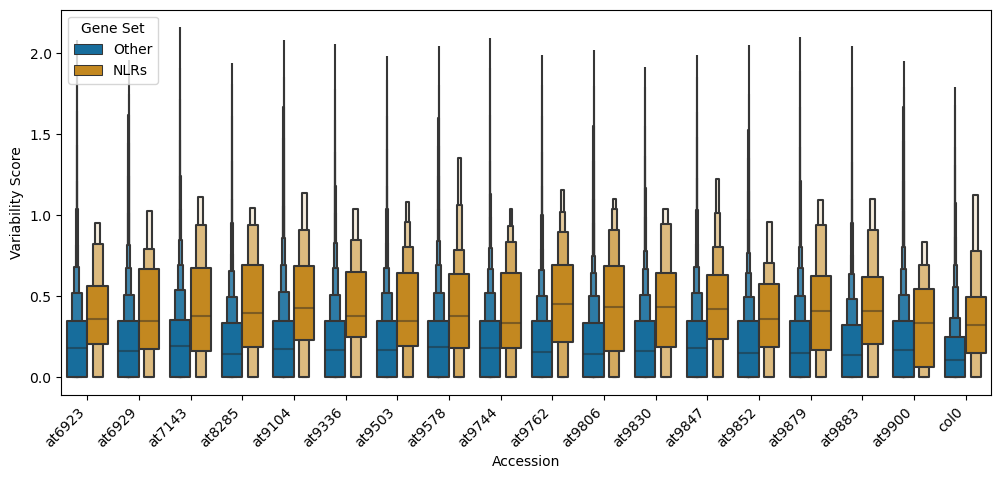

In [57]:
sns.set_palette(sns.color_palette("colorblind"))
figure(figsize=(12, 5))

var_boxen = sns.boxenplot(data=var_scores_all.replace({"other":"Other", "nlr":"NLRs"}), 
                          x="accession", y="var_score", hue="type", hue_order=["Other","NLRs"], dodge=True, showfliers=False)

var_boxen.set_xticklabels(var_scores_all["accession"].unique().tolist(), rotation=45,horizontalalignment='right')
var_boxen.set_xlabel("Accession")
var_boxen.set_ylabel("Variability Score")
var_boxen.legend(title='Gene Set', loc='upper left')

fig = var_boxen.get_figure()
fig.savefig("var_score_accession_boxen.png", bbox_inches='tight')

/tmp/ipykernel_196451/4274772304.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  var_strip.set_xticklabels(var_scores_all["accession"].unique().tolist(), rotation=45,horizontalalignment='right')


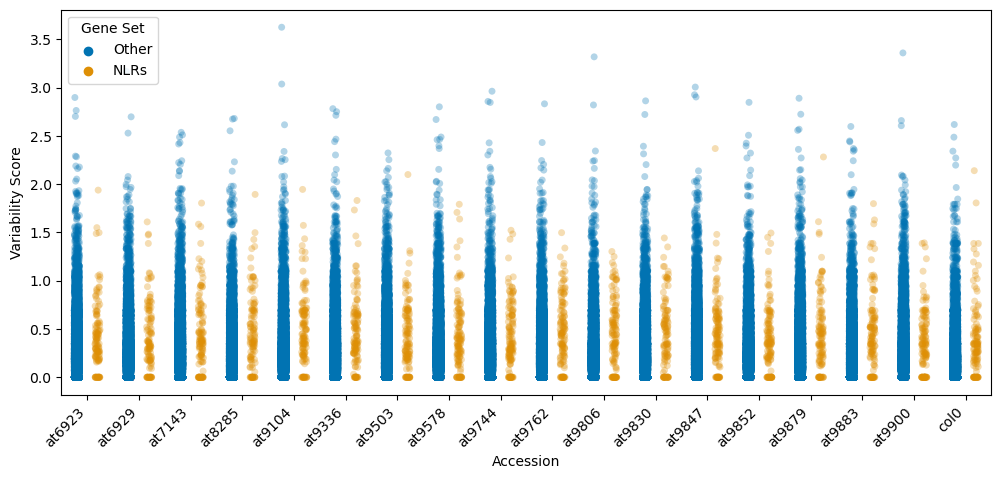

In [14]:
sns.set_palette(sns.color_palette("colorblind"))
figure(figsize=(12, 5))

var_strip=sns.stripplot(data=var_scores_all.replace({"other":"Other", "nlr":"NLRs"}), x="accession", y="var_score", hue="type", alpha=0.3, hue_order=["Other","NLRs"], dodge=True)

var_strip.set_xticklabels(var_scores_all["accession"].unique().tolist(), rotation=45,horizontalalignment='right')
var_strip.set_xlabel("Accession")
var_strip.set_ylabel("Variability Score")
var_strip.legend(title='Gene Set', loc='upper left')

fig = var_strip.get_figure()
fig.savefig("var_score_accession.png", bbox_inches='tight')
# Subsample! Different order (other)vs(nlr)

### MWU

In [120]:
p_vals={}
mwu_stat={}
for acc in tqdm(var_scores_all["accession"].unique().tolist()):
    p_vals[acc]=[]
    mwu_stat[acc]=[]
    
    nlr = var_scores_all.loc[(var_scores_all["type"]=="nlr")&(var_scores_all["accession"]==acc)]
    other = var_scores_all.loc[~(var_scores_all["type"]=="nlr")&(var_scores_all["accession"]==acc)]
    
    np.random.seed(42)
    seeds = np.random.choice(range(999999), size=100, replace=False)

    # get snapshot of one iteration
    for i in range(len(seeds)):
        stat, p_value = mannwhitneyu(nlr["var_score"], other["var_score"].sample(len(nlr), random_state=seeds[i]))
        p_vals[acc].append(p_value)
        mwu_stat[acc].append(stat)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:06<00:00,  2.64it/s]


In [121]:
p=pd.DataFrame(p_vals)
max_p=p.melt().groupby("variable")["value"].apply("max")
all_p=p.melt()
all_p=all_p.loc[all_p["value"]>0.05]
all_p=all_p.groupby("variable")["value"].apply(lambda x: len(x))
p_values=pd.concat([max_p,all_p],axis=1)
p_values

,value,value
variable,,
at6923,9.804005e-04,NaN
at6929,2.764457e-03,NaN
at7143,7.000981e-04,NaN
at8285,5.887036e-06,NaN
at9104,8.103596e-07,NaN
at9336,8.803336e-06,NaN
at9503,1.203531e-03,NaN
at9578,9.688351e-03,NaN
at9744,3.960675e-03,NaN


### T-test

In [128]:
from scipy import stats
p_vals_t={}
t_stat={}
for acc in tqdm(var_scores_all["accession"].unique().tolist()):
    p_vals_t[acc]=[]
    t_stat[acc]=[]
    
    nlr = var_scores_all.loc[(var_scores_all["type"]=="nlr")&(var_scores_all["accession"]==acc)]
    other = var_scores_all.loc[~(var_scores_all["type"]=="nlr")&(var_scores_all["accession"]==acc)]
    
    np.random.seed(42)
    seeds = np.random.choice(range(999999), size=10000, replace=False)

    # get snapshot of one iteration
    for i in range(len(seeds)):
        stat, p_value = stats.ttest_ind(nlr["var_score"], other["var_score"].sample(len(nlr), random_state=seeds[i]), equal_var=False)
        p_vals_t[acc].append(p_value)
        t_stat[acc].append(stat)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [02:34<00:00,  8.56s/it]


In [130]:
p_t=pd.DataFrame(p_vals)
max_p_t=p_t.melt().groupby("variable")["value"].apply("max")
all_p_t=p_t.melt()
all_p_t=all_p_t.loc[all_p_t["value"]>0.05]
all_p_t=all_p_t.groupby("variable")["value"].apply(lambda x: len(x))
p_values_t=pd.concat([max_p_t,all_p_t],axis=1)
p_values_t.columns = [["p_val","counts"]]
p_values_t

,p_val,counts
variable,,
at6923,9.804005e-04,NaN
at6929,2.764457e-03,NaN
at7143,7.000981e-04,NaN
at8285,5.887036e-06,NaN
at9104,8.103596e-07,NaN
at9336,8.803336e-06,NaN
at9503,1.203531e-03,NaN
at9578,9.688351e-03,NaN
at9744,3.960675e-03,NaN


In [17]:
# perform mann whitney test
nlr = var_scores_all.loc[(var_scores_all["type"]=="nlr")&(var_scores_all["accession"]=="at9900")]
other = var_scores_all.loc[~(var_scores_all["type"]=="nlr")&(var_scores_all["accession"]=="at9900")]

stat, p_value = mannwhitneyu(nlr["var_score"], other["var_score"].sample(len(nlr)))
print('Statistics=%.2f, p=%.2f' % (stat, p_value))
# Level of significance
alpha = 0.05
# conclusion
if p_value < alpha:
    print('Reject Null Hypothesis (Significant difference between two samples)')
else:
    print('Do not Reject Null Hypothesis (No significant difference between two samples)')

Statistics=10526.00, p=0.00
Reject Null Hypothesis (Significant difference between two samples)


In [18]:
MWU=pd.DataFrame()
for acc in var_scores_all["accession"].unique().tolist():
    # perform mann whitney test
    nlr = var_scores_all.loc[(var_scores_all["type"]=="nlr")&(var_scores_all["accession"]==acc)]
    other = var_scores_all.loc[~(var_scores_all["type"]=="nlr")&(var_scores_all["accession"]==acc)]

    stat, p_value = mannwhitneyu(nlr["var_score"], other["var_score"].sample(len(nlr)))
    out=[stat,p_value]
    MWU[acc]=out
    #print('Statistics=%.2f, p=%.2f' % (stat, p_value))
MWU=MWU.T
MWU.columns=["Statistics","P value"]
MWU

,Statistics,P value
at6923,11246.5,7.932934e-09
at6929,8868.5,8.258501e-05
at7143,10090.0,1.825406e-05
at8285,9848.5,2.709490e-08
at9104,11346.0,7.367942e-11
at9336,11156.0,6.633465e-10
at9503,11561.5,9.516811e-09
at9578,11334.5,3.831698e-07
at9744,13124.5,3.739927e-08
at9762,12964.5,4.282924e-14


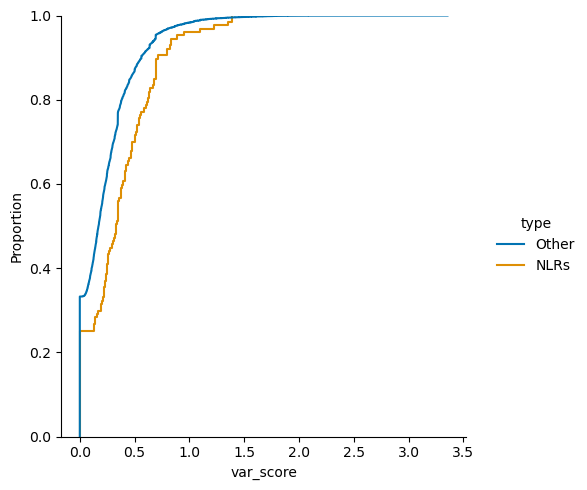

In [19]:
sns.displot(var_scores_all.loc[var_scores_all["accession"]=="at9900"].replace({"other":"Other", "nlr":"NLRs"}), x="var_score", hue="type",hue_order=["Other","NLRs"], kind="ecdf")

### Example of the variability of one specific AS event

Intron retention

/tmp/ipykernel_170781/3045815134.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  var_ir.set_xticklabels(var_scores_all["accession"].unique().tolist(), rotation=45,horizontalalignment='right')


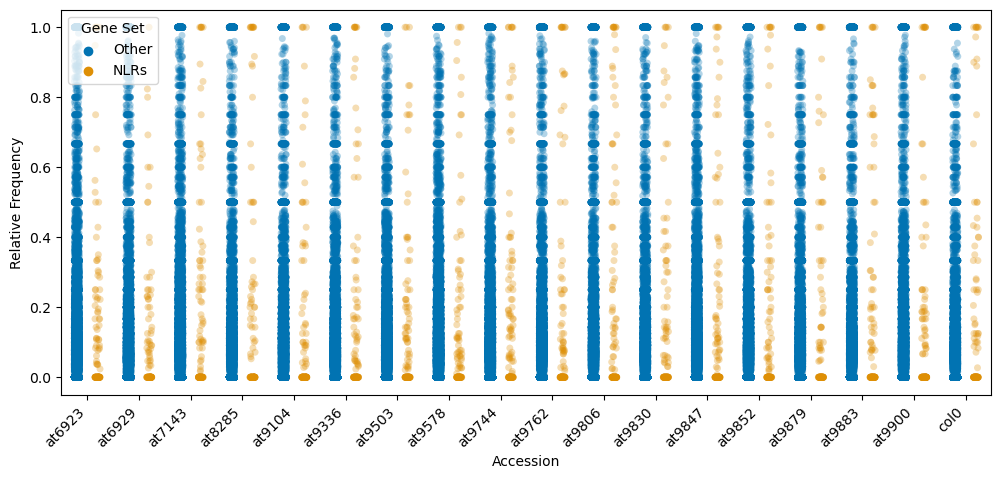

In [20]:
sns.set_palette(sns.color_palette("colorblind"))
figure(figsize=(12, 5))

var_ir=sns.stripplot(data=var_scores_all.replace({"other":"Other", "nlr":"NLRs"}), x="accession", y="intron_retention", hue="type", alpha=0.3, hue_order=["Other","NLRs"], dodge=True)

var_ir.set_xticklabels(var_scores_all["accession"].unique().tolist(), rotation=45,horizontalalignment='right')
var_ir.set_xlabel("Accession")
var_ir.set_ylabel("Relative Frequency")
var_ir.legend(title='Gene Set', loc='upper left')

fig = var_ir.get_figure()
fig.savefig("intron_retention_accession.png", bbox_inches='tight')

Fusion

/tmp/ipykernel_170781/2460104002.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  var_fusion.set_xticklabels(var_scores_all["accession"].unique().tolist(), rotation=45,horizontalalignment='right')


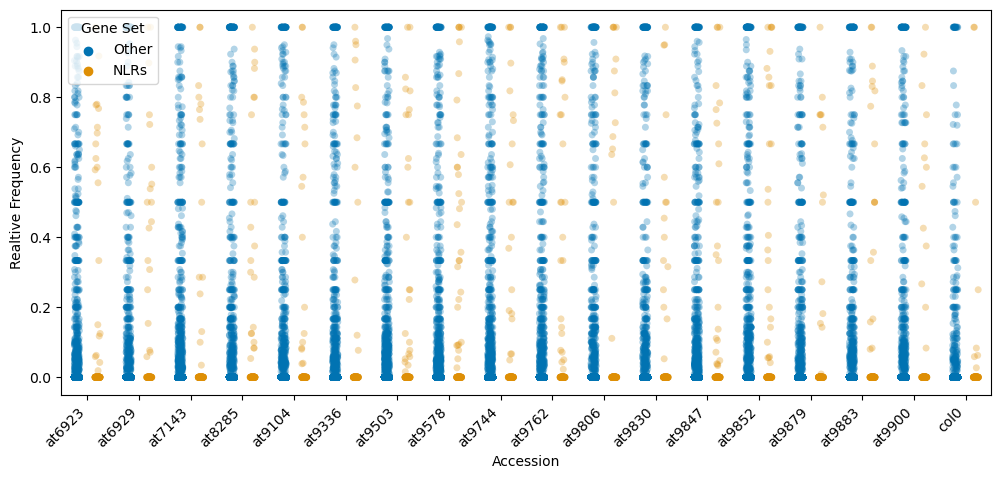

In [21]:
#sns.set_palette(sns.color_palette("colorblind"))
figure(figsize=(12, 5))

var_fusion=sns.stripplot(data=var_scores_all.replace({"other":"Other", "nlr":"NLRs"}), x="accession", y="fusion", hue="type", alpha=0.3, hue_order=["Other","NLRs"], dodge=True)

var_fusion.set_xticklabels(var_scores_all["accession"].unique().tolist(), rotation=45,horizontalalignment='right')
var_fusion.set_xlabel("Accession")
var_fusion.set_ylabel("Realtive Frequency")
var_fusion.legend(title='Gene Set', loc='upper left')

fig = var_fusion.get_figure()
fig.savefig("fusion_accession.png", bbox_inches='tight')

### Create a representative dataset

In [103]:
var_scores_sub=pd.DataFrame()
lengths=[]
for acc in tqdm(var_scores_all["accession"].unique().tolist()):
    nlr = var_scores_all.loc[(var_scores_all["type"]=="nlr")&(var_scores_all["accession"]==acc)]
    other = var_scores_all.loc[~(var_scores_all["type"]=="nlr")&(var_scores_all["accession"]==acc)]
    lengths.append(len(nlr))
    other=other.sample(len(nlr), random_state=79954)
    var_scores_sub=pd.concat([var_scores_sub, nlr, other])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  8.32it/s]


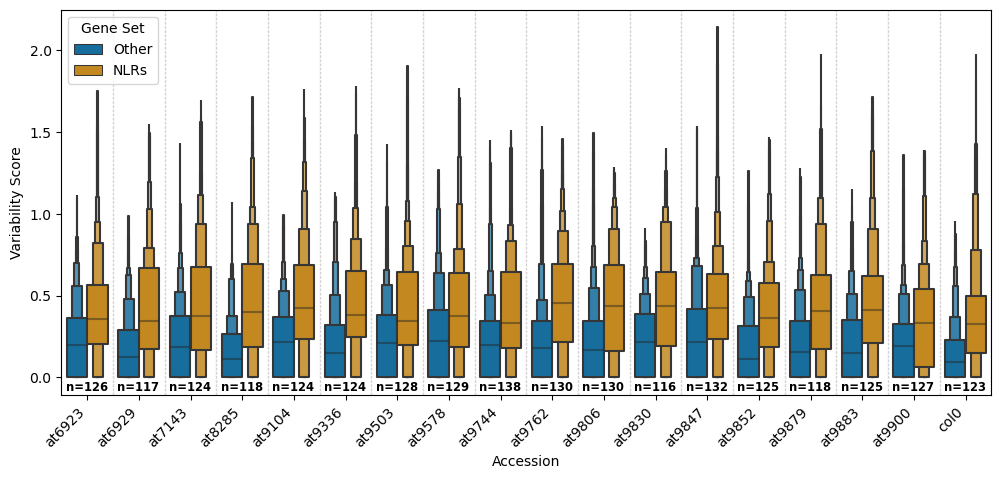

In [108]:
sns.set_palette(sns.color_palette("colorblind"))
figure(figsize=(12, 5))

var_boxen_sub = sns.boxenplot(data=var_scores_sub.replace({"other":"Other", "nlr":"NLRs"}), 
                          x="accession", y="var_score", hue="type", hue_order=["Other","NLRs"], dodge=True, k_depth="proportion", showfliers=False)

var_boxen_sub.set_xticklabels(var_scores_all["accession"].unique().tolist(), rotation=45,horizontalalignment='right')
var_boxen_sub.set_xlabel("Accession")
var_boxen_sub.set_ylabel("Variability Score")
var_boxen_sub.legend(title='Gene Set', loc='upper left')

[var_boxen_sub.axvline(x+.5,color='lightgrey', dashes=(2,1), linewidth=1) for x in var_boxen_sub.get_xticks()]

for i,j in enumerate(lengths):
    plt.text(i-0.42, -0.08, f"n={j}", horizontalalignment='left', size='small', color='black', weight='semibold')

fig = var_boxen_sub.get_figure()
fig.savefig("var_score_accession_boxen_sub.png", bbox_inches='tight')

/tmp/ipykernel_196451/4088203544.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  var_strip.set_xticklabels(var_scores_all["accession"].unique().tolist(), rotation=45,horizontalalignment='right')


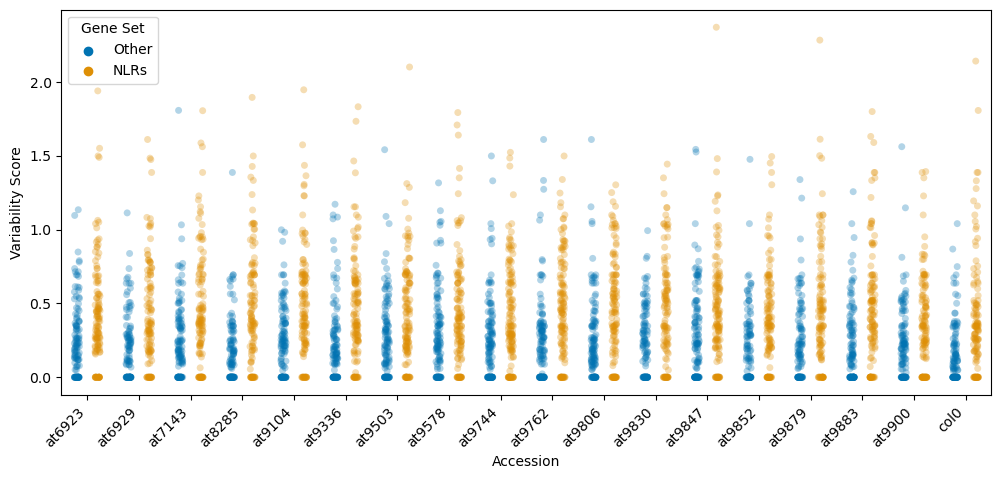

In [85]:
sns.set_palette(sns.color_palette("colorblind"))
figure(figsize=(12, 5))

var_strip=sns.stripplot(data=var_scores_sub.replace({"other":"Other", "nlr":"NLRs"}), x="accession", y="var_score", hue="type", alpha=0.3, hue_order=["Other","NLRs"], dodge=True)

var_strip.set_xticklabels(var_scores_all["accession"].unique().tolist(), rotation=45,horizontalalignment='right')
var_strip.set_xlabel("Accession")
var_strip.set_ylabel("Variability Score")
var_strip.legend(title='Gene Set', loc='upper left')

fig = var_strip.get_figure()
fig.savefig("var_score_accession_sub.png", bbox_inches='tight')
# Subsample! Different order (other)vs(nlr)

In [38]:
def show_gene(acc, name):
    print("Gene entitiy:")
    goi=var_scores_all.loc[(var_scores_all["accession"]==acc)&(var_scores_all["gene"]==name)].copy()
    for c in goi.columns:
        if goi[c].sum()==0:
            goi.drop(c, inplace=True, axis=1)
    print(goi)
    
    print("Individual isoforms:")
    out=all_types.loc[(all_types["accession"]==acc)&(all_types["gene"]==name)]
    print(out)
    return out

In [189]:
var_score_nlr=var_scores_all.loc[(var_scores_all["type"]=="nlr")&(var_scores_all["accession"]=="col0")]

In [214]:
var_score_nlr=var_score_nlr.sort_values(by="var_score", ascending=False)
var_score_nlr.index=[*range(1, len(var_score_nlr)+1)]
var_score_nlr

,alternative_3end5end,at_least_one_novel_splicesite,alternative_3end,intron_retention,mono-exon,3prime_fragment,multi-exon,5prime_fragment,combination_of_known_splicesites,reference_match,alternative_5end,internal_fragment,mono-exon_by_intron_retention,combination_of_known_junctions,fusion,cat_score,orf_score,var_score,gene,type,accession
1,0.0,0.0,0.0,0.972222,0.027778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.754274,2.837329,2.140122,G10806,nlr,col0
2,0.0,0.0,0.0,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1.805976,1.805976,G8810,nlr,col0
3,0.0,0.0,0.0,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1.386294,1.386294,G14851,nlr,col0
4,0.0,0.0,0.0,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1.386294,1.386294,G1061,nlr,col0
5,0.0,0.0,0.0,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1.329661,1.329661,G2874,nlr,col0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.000000,0.000000,0.000000,G14679,nlr,col0
120,0.0,0.0,0.0,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.000000,G4664,nlr,col0
121,0.0,0.0,0.0,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.000000,G1180,nlr,col0
122,0.0,0.0,0.0,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.000000,G10628,nlr,col0


In [215]:
var_score_nlr.head(15)

,alternative_3end5end,at_least_one_novel_splicesite,alternative_3end,intron_retention,mono-exon,3prime_fragment,multi-exon,5prime_fragment,combination_of_known_splicesites,reference_match,alternative_5end,internal_fragment,mono-exon_by_intron_retention,combination_of_known_junctions,fusion,cat_score,orf_score,var_score,gene,type,accession
1,0.0,0.000000,0.0,0.972222,0.027778,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.000000,0.0,0.0,0.754274,2.837329,2.140122,G10806,nlr,col0
2,0.0,0.000000,0.0,0.000000,1.000000,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.000000,0.0,0.0,1.000000,1.805976,1.805976,G8810,nlr,col0
3,0.0,0.000000,0.0,0.000000,1.000000,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.000000,0.0,0.0,1.000000,1.386294,1.386294,G14851,nlr,col0
4,0.0,0.000000,0.0,0.000000,1.000000,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.000000,0.0,0.0,1.000000,1.386294,1.386294,G1061,nlr,col0
5,0.0,0.000000,0.0,1.000000,0.000000,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.000000,0.0,0.0,1.000000,1.329661,1.329661,G2874,nlr,col0
6,0.0,0.000000,0.0,0.000000,1.000000,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.000000,0.0,0.0,1.000000,1.277034,1.277034,G11393,nlr,col0
7,0.0,0.000000,0.0,0.909091,0.000000,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.090909,0.0,0.0,0.675325,1.767761,1.193813,G10985,nlr,col0
8,0.0,0.000000,0.0,0.000000,1.000000,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.000000,0.0,0.0,1.000000,1.159589,1.159589,G3035,nlr,col0
9,0.0,0.000000,0.0,1.000000,0.000000,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.000000,0.0,0.0,1.000000,1.098612,1.098612,G14807,nlr,col0
10,0.0,0.000000,0.0,0.000000,0.000000,0.00,1.0,0.00,0.0,0.00,0.0,0.0,0.000000,0.0,0.0,1.000000,1.054920,1.054920,G3080,nlr,col0


In [210]:
var_score_nlr.loc[var_score_nlr["gene"]=="G14620"]

,alternative_3end5end,at_least_one_novel_splicesite,alternative_3end,intron_retention,mono-exon,3prime_fragment,multi-exon,5prime_fragment,combination_of_known_splicesites,reference_match,alternative_5end,internal_fragment,mono-exon_by_intron_retention,combination_of_known_junctions,fusion,cat_score,orf_score,var_score,gene,type,accession
15,0.0,0.0,0.8,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.44,2.025326,0.891144,G14620,nlr,col0


In [216]:
out = show_gene("col0","G10806")

Gene entitiy:
   intron_retention  mono-exon  cat_score  orf_score  var_score    gene type  \
0          0.972222   0.027778   0.754274   2.837329   2.140122  G10806  nlr   

  accession  
0      col0  
Individual isoforms:
         gene    isoform accession associated_gene associated_transcript  \
32741  G10806   G10806.1      col0       AT4G16890                 novel   
32742  G10806  G10806.10      col0       AT4G16890           AT4G16890.1   
32743  G10806  G10806.11      col0       AT4G16890                 novel   
32744  G10806  G10806.12      col0       AT4G16890                 novel   
32745  G10806  G10806.13      col0       AT4G16890                 novel   
32746  G10806  G10806.14      col0       AT4G16890           AT4G16890.1   
32747  G10806  G10806.15      col0       AT4G16890           AT4G16890.1   
32748  G10806  G10806.16      col0       AT4G16890           AT4G16890.1   
32749  G10806  G10806.17      col0       AT4G16890           AT4G16890.1   
32750  G10806  G

In [200]:
print(len(out))

10


In [201]:
len(all_types.loc[(all_types["accession"]=="col0")&(all_types["gene"]=="G14620")]["Sqanti_ORF_seq"].value_counts())

8

### Include all gene sets:

In [22]:
var_scores_all=pd.DataFrame()
for acc in tqdm(all_types["accession"].unique().tolist()):
    
    nlr_acc=all_types.loc[(all_types["accession"]==f"{acc}")].copy()
    acc_var=pd.DataFrame()
    
    #nlr_acc=all_types.loc[(all_types["accession"]==f"{acc}")&(all_types["type"]=="nlr")].copy()
    for i in nlr_acc.groupby(by="gene", as_index=False):
        gene_var=iso_var(i[1])
        gene_var["gene"]=i[0]
        if "nlr" in i[1]["type"].tolist():
            gene_var["type"]="nlr"
            acc_var=pd.concat([acc_var, gene_var])
            continue
        elif "housekeeping" in i[1]["type"].tolist():
            gene_var["type"]="house"
            acc_var=pd.concat([acc_var, gene_var])
            continue
        elif "busco" in i[1]["type"].tolist():
            gene_var["type"]="busco"
            acc_var=pd.concat([acc_var, gene_var])
            continue
        else:
            gene_var["type"]="other"
            acc_var=pd.concat([acc_var, gene_var])
            continue

    #acc_df=pd.DataFrame({"value":acc_var, "gene":acc_gene, "type":acc_type})
    acc_var["accession"]=acc
    var_scores_all=pd.concat([var_scores_all, acc_var]).fillna(0)
    #print(var_scores_all["type"].value_counts())
    #print(nlr_acc.groupby(by="gene", as_index=False))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [25:54<00:00, 86.36s/it]


In [23]:
var_scores_all=pd.read_pickle("var_scores_nlr-refs.pkl")

/tmp/ipykernel_170781/3793093017.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  var_refgenes.set_xticklabels(var_scores_all["accession"].unique().tolist(), rotation=45,horizontalalignment='right')


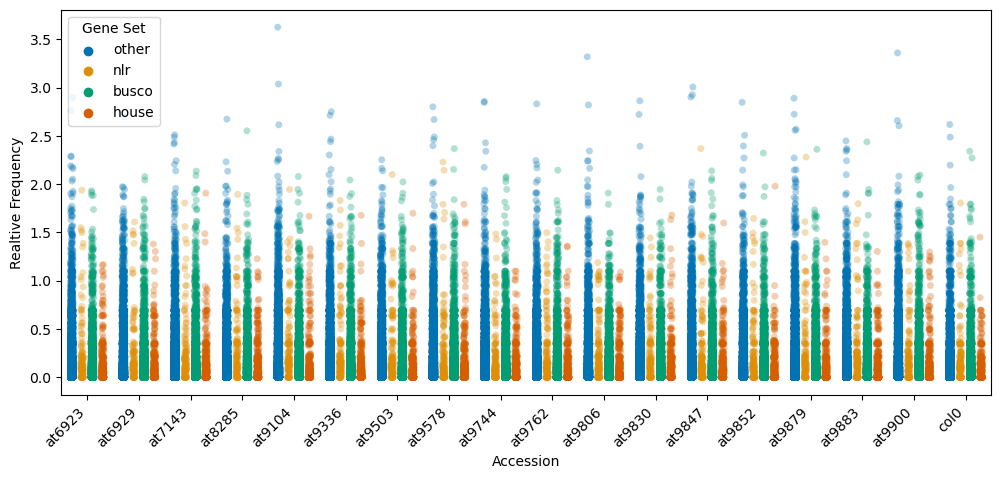

In [24]:
sns.set_palette(sns.color_palette("colorblind"))
figure(figsize=(12, 5))
var_refgenes=sns.stripplot(data=var_scores_all, x="accession", y="var_score", hue="type", alpha=0.3, hue_order=["other","nlr","busco","house"], dodge=True)

var_refgenes.set_xticklabels(var_scores_all["accession"].unique().tolist(), rotation=45,horizontalalignment='right')
var_refgenes.set_xlabel("Accession")
var_refgenes.set_ylabel("Realtive Frequency")
var_refgenes.legend(title='Gene Set', loc='upper left')

fig = var_refgenes.get_figure()
fig.savefig("var_score_accession_genesets.png", bbox_inches='tight')

In [25]:
var_scores_all.to_pickle("var_scores_nlr-refs.pkl")